In [2]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

Load file fasta fiel

In [3]:
import pyBigWig
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # optional, for progress bar

file_path = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/gc5Base_chrX.txt"
import pandas as pd

# Load the file — tab-delimited
df_gc = pd.read_csv(file_path, sep="\t", header=None)

# Name the columns (standard BedGraph format)
df_gc.columns = ["chrom", "start", "end", "value"]

# Show the first few rows
df_gc.head()



,chrom,start,end,value
0,chrX,0,5,80.0
1,chrX,5,10,40.0
2,chrX,10,15,80.0
3,chrX,15,20,40.0
4,chrX,20,25,100.0


## loading eigenvectors using kasper code

In [4]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)
    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

In [5]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentracks"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_10Mb.csv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head())

Generated variable names: ['sperm_e1_100kb_10Mb_comps', 'round_spermatid_e1_100kb_10Mb_comps', 'pachytene_spermatocyte_e1_100kb_10Mb_comps', 'spermatogonia_e1_100kb_10Mb_comps', 'fibroblast_e1_100kb_10Mb_comps']
Generated variable names: ['sperm_e1_100kb_10Mb_edges', 'round_spermatid_e1_100kb_10Mb_edges', 'pachytene_spermatocyte_e1_100kb_10Mb_edges', 'spermatogonia_e1_100kb_10Mb_edges', 'fibroblast_e1_100kb_10Mb_edges']
Generated compartment A and B variables: ['sperm_e1_100kb_10Mb_edges_AB', 'sperm_e1_100kb_10Mb_edges_A', 'sperm_e1_100kb_10Mb_edges_B', 'round_spermatid_e1_100kb_10Mb_edges_AB', 'round_spermatid_e1_100kb_10Mb_edges_A', 'round_spermatid_e1_100kb_10Mb_edges_B', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_AB', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_A', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_B', 'spermatogonia_e1_100kb_10Mb_edges_AB', 'spermatogonia_e1_100kb_10Mb_edges_A', 'spermatogonia_e1_100kb_10Mb_edges_B', 'fibroblast_e1_100kb_10Mb_edges_AB', 'fibroblast_e1_1

## not nesesary

In [6]:
for edge_var in generated_edges:
    comp_AB_name = f"{edge_var}_AB"
    if comp_AB_name in globals():
        print(f"Head of {comp_AB_name}:")
        print(globals()[comp_AB_name].head())
        print()

Head of sperm_e1_100kb_10Mb_edges_AB:
  comp       start         end chrom
0    A   2500000.0   2500001.0  chrX
1    A   8300000.0   8300001.0  chrX
2    A   9800000.0   9800001.0  chrX
3    A  10000000.0  10000001.0  chrX
4    B  10400000.0  10400001.0  chrX

Head of round_spermatid_e1_100kb_10Mb_edges_AB:
  comp      start        end chrom
0    A  7900000.0  7900001.0  chrX
1    A  8000000.0  8000001.0  chrX
2    A  8400000.0  8400001.0  chrX
3    B  8500000.0  8500001.0  chrX
4    A  8900000.0  8900001.0  chrX

Head of pachytene_spermatocyte_e1_100kb_10Mb_edges_AB:
  comp       start         end chrom
0    A   9000000.0   9000001.0  chrX
1    A   9100000.0   9100001.0  chrX
2    B   9800000.0   9800001.0  chrX
3    A  10000000.0  10000001.0  chrX
4    B  10500000.0  10500001.0  chrX

Head of spermatogonia_e1_100kb_10Mb_edges_AB:
  comp       start         end chrom
0    A   9700000.0   9700001.0  chrX
1    A  10000000.0  10000001.0  chrX
2    B  10100000.0  10100001.0  chrX
3    A  

## remapping


In [6]:
#     # Clean and sort
# sperm_clean = sperm_e1_100kb_10Mb_edges_AB.dropna(subset=["start", "end"]).copy()
# sperm_clean["start"] = sperm_clean["start"].astype(int)
# sperm_clean["end"] = sperm_clean["end"].astype(int)
# df_gc = df_gc.dropna(subset=["start", "end"]).copy()
# df_gc["start"] = df_gc["start"].astype(int)
# df_gc["end"] = df_gc["end"].astype(int)

# sperm_clean = sperm_clean.sort_values(by=['chrom', 'start', 'end'])
# df_gc = df_gc.sort_values(by=['chrom', 'start', 'end'])

# result = remap_interval_data(df_gc, sperm_clean, include_prox_coord=True)
# # Post-process
# result["mid"] = (result["start"] + result["end"]) / 2
# result["absmid"] = result["mid"].abs()
# result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")
# result.to_csv("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/sperm_e1_100kb_10Mb_edges_AB_gc_remap.txt", sep="\t", index=False)

# print(result.head())

# #print(result["start_prox"].unique())

# GC Content Remapping Script

This script remaps GC content data to genomic edge data for multiple samples and saves the results to text files.

## Steps

1. **Define Input DataFrames**
   A dictionary `df_for_remapping` maps sample names to their corresponding edge DataFrames. These DataFrames contain genomic interval data for compartments A and B.

2. **Clean GC Reference File**
   The GC content DataFrame `df_gc` is cleaned:
   - Rows with missing `start` or `end` values are dropped.
   - Coordinates are cast to integers.
   - Sorted by chromosome and genomic position.

3. **Iterate Over Samples**
   For each sample:
   - The edge DataFrame is cleaned similarly (drop missing values, cast to `int`, sort).
   - GC content is remapped to the edge intervals using the `remap_interval_data` function, with proximal coordinate inclusion.
   - Additional columns (`mid`, `absmid`) are computed to represent the interval midpoint and its absolute value.
   - Rows with missing key values are dropped to ensure a clean result.

4. **Save Output**
   The remapped and post-processed result is saved as a tab-separated `.txt` file in the `remapping/` directory, named according to the sample.

5. **Progress Logging**
   A message is printed for each sample once processing is complete.


In [ ]:
# Define all input edge DataFrames by name
# df_for_remapping = {
#     "sperm_e1_100kb_10Mb_edges_AB": sperm_e1_100kb_10Mb_edges_AB,
#     "round_spermatid_e1_100kb_10Mb_edges_AB": round_spermatid_e1_100kb_10Mb_edges_AB,
#     "pachytene_spermatocyte_e1_100kb_10Mb_edges_AB": pachytene_spermatocyte_e1_100kb_10Mb_edges_AB,
#     "spermatogonia_e1_100kb_10Mb_edges_AB": spermatogonia_e1_100kb_10Mb_edges_AB,
#     "fibroblast_e1_100kb_10Mb_edges_AB": fibroblast_e1_100kb_10Mb_edges_AB
# }

# # Clean the GC reference file once
# df_gc = df_gc.dropna(subset=["start", "end"]).copy()
# df_gc["start"] = df_gc["start"].astype(int)
# df_gc["end"] = df_gc["end"].astype(int)
# df_gc = df_gc.sort_values(by=["chrom", "start", "end"])


# for name, df in df_for_remapping.items():
#     #print(f"Processing {name}")
#             # Clean and sort
#     df_clean = df.dropna(subset=["start", "end"]).copy()
#     df_clean["start"] = df_clean["start"].astype(int)
#     df_clean["end"] = df_clean["end"].astype(int)

#     #print(df_clean.head())

#     result = remap_interval_data(df_gc, df_clean, include_prox_coord=True)
#     # Post-process
#     result["mid"] = (result["start"] + result["end"]) / 2
#     result["absmid"] = result["mid"].abs()

#     # Map comp from start_prox using df_clean
#     start_to_comp = df_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
#     result["comp"] = result["start_prox"].map(start_to_comp)

#     result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")
#     result.to_csv(f"/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/{name}_gc_remap.txt", sep="\t", index=False)
#     print(f"{name} done")

# print("finaly done ")

sperm_e1_100kb_10Mb_edges_AB done
round_spermatid_e1_100kb_10Mb_edges_AB done
pachytene_spermatocyte_e1_100kb_10Mb_edges_AB done
spermatogonia_e1_100kb_10Mb_edges_AB done
fibroblast_e1_100kb_10Mb_edges_AB done
finaly done 


In [1]:
import pandas as pd

# Load the file into a DataFrame
file_path1 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/fibroblast_e1_100kb_10Mb_edges_AB_gc_remap.txt"
fibroblast = pd.read_csv(file_path1, sep="\t")
print("fibroblast:", fibroblast.shape)
file_path2 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/sperm_e1_100kb_10Mb_edges_AB_gc_remap.txt"
sperm = pd.read_csv(file_path2, sep="\t")
print("sperm:", sperm.shape)
file_path3 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/round_spermatid_e1_100kb_10Mb_edges_AB_gc_remap.txt"
round_spermatid = pd.read_csv(file_path3, sep="\t")
print("round_spermatid:", round_spermatid.shape)
file_path4 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/pachytene_spermatocyte_e1_100kb_10Mb_edges_AB_gc_remap.txt"
pachytene_spermatocyte= pd.read_csv(file_path4, sep="\t")
print("pachytene_spermatocyte:", pachytene_spermatocyte.shape)
file_path5 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/spermatogonia_e1_100kb_10Mb_edges_AB_gc_remap.txt"
spermatogonia= pd.read_csv(file_path5, sep="\t")
print("spermatogonia:", spermatogonia.shape)
# Display the first few rows
print(fibroblast.head())


fibroblast: (21319987, 11)
sperm: (20818795, 11)
round_spermatid: (20567239, 11)
pachytene_spermatocyte: (19624881, 11)
spermatogonia: (20280723, 11)
   start   end  start_prox  end_prox chrom  start_orig  end_orig  value   mid  \
0    4.0   9.0    800000.0  800001.0  chrX      800005    800010   60.0   6.5   
1    9.0  14.0    800000.0  800001.0  chrX      800010    800015    0.0  11.5   
2   14.0  19.0    800000.0  800001.0  chrX      800015    800020   60.0  16.5   
3   19.0  24.0    800000.0  800001.0  chrX      800020    800025   20.0  21.5   
4   24.0  29.0    800000.0  800001.0  chrX      800025    800030   40.0  26.5   

   absmid comp  
0     6.5    B  
1    11.5    B  
2    16.5    B  
3    21.5    B  
4    26.5    B  


In [7]:
### making the function


'''Step 1
def filter into in A and B compartment:

#seperate into A and B
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
return avarges_A, avarges_B

'''
def filter_into_A_B_compartments(result):
    """
    Splits the input DataFrame into A and B compartments based on sign of 'start' and compartment identity.
    
    Parameters:
        result (pd.DataFrame): Must include columns 'comp' and 'start'.
    
    Returns:
        A_val (pd.DataFrame): Entries where position is consistent with Compartment A.
        B_val (pd.DataFrame): Entries where position is consistent with Compartment B.
    """
    # Entries within A compartment (left of origin if A, right if B)
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |     # is less than 0
        ((result['comp'] == 'B') & (result['start'] > 0))       # is greater than 0
    ].copy()

    # Entries within B compartment (right of origin if A, left if B)
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
    ].copy()

    return A_val, B_val

fibroblast_A, fibroblast_B = filter_into_A_B_compartments(fibroblast)
print(fibroblast_A.head())
print(fibroblast_B.head())





   start   end  start_prox  end_prox chrom  start_orig  end_orig  value   mid  \
0    4.0   9.0    800000.0  800001.0  chrX      800005    800010   60.0   6.5   
1    9.0  14.0    800000.0  800001.0  chrX      800010    800015    0.0  11.5   
2   14.0  19.0    800000.0  800001.0  chrX      800015    800020   60.0  16.5   
3   19.0  24.0    800000.0  800001.0  chrX      800020    800025   20.0  21.5   
4   24.0  29.0    800000.0  800001.0  chrX      800025    800030   40.0  26.5   

   absmid comp  
0     6.5    B  
1    11.5    B  
2    16.5    B  
3    21.5    B  
4    26.5    B  
            start        end  start_prox   end_prox chrom  start_orig  \
184135 -1299995.0 -1299999.5   3400000.0  3400001.0  chrX     2099995   
184136 -1299990.0 -1299995.0   3400000.0  3400001.0  chrX     2100005   
184137 -1299985.0 -1299990.0   3400000.0  3400001.0  chrX     2100010   
184138 -1299970.0 -1299985.0   3400000.0  3400001.0  chrX     2100015   
184139 -1299960.0 -1299970.0   3400000.0  3400

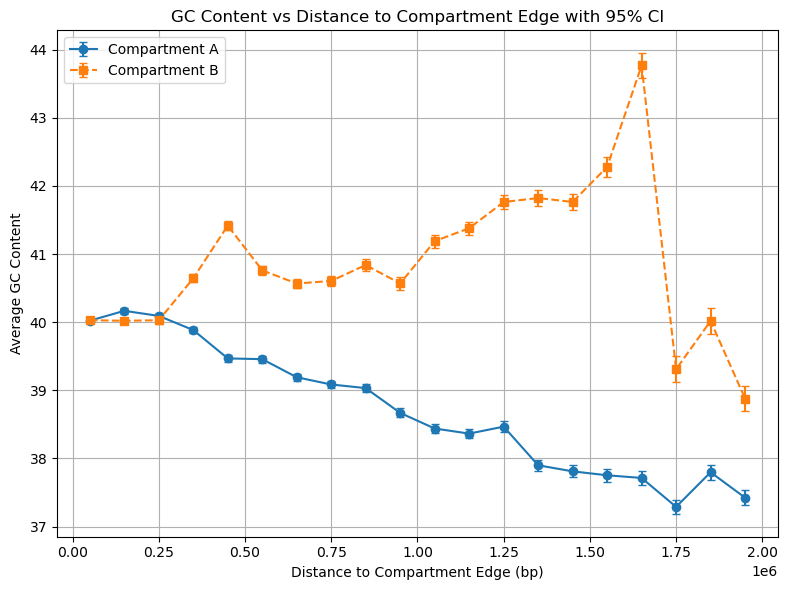

In [21]:
def plot_gc_by_compartment_with_error(A_df, B_df, num_bins=20, max_dist=2_000_000):
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    def compute_bin_stats(df):
        means = []
        sems = []

        for i in range(len(bins) - 1):
            bin_data = df[(df['absmid'] >= bins[i]) & (df['absmid'] < bins[i + 1])]
            gc_values = bin_data['value'].dropna()

            if len(gc_values) > 0:
                means.append(gc_values.mean())
                sems.append(gc_values.std(ddof=1) / np.sqrt(len(gc_values)))
            else:
                means.append(np.nan)
                sems.append(np.nan)

        means = np.array(means)
        sems = np.array(sems)
        ci_95 = 1.96 * sems  # <- Apply 95% confidence interval here
        return means, ci_95

    # Compute 95% CI for both compartments
    A_means, A_ci = compute_bin_stats(A_df)
    B_means, B_ci = compute_bin_stats(B_df)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.errorbar(bin_centers, A_means, yerr=A_ci, label="Compartment A",
                 marker='o', linestyle='-', capsize=3)
    plt.errorbar(bin_centers, B_means, yerr=B_ci, label="Compartment B",
                 marker='s', linestyle='--', capsize=3)

    plt.xlabel("Distance to Compartment Edge (bp)")
    plt.ylabel("Average GC Content")
    plt.title("GC Content vs Distance to Compartment Edge with 95% CI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_gc_by_compartment_with_error(fibroblast_A, fibroblast_B)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gc_by_compartment_with_error(A_df, B_df, num_bins=20, max_dist=2_000_000, return_counts=False):
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    def compute_bin_stats(df):
        means, sems, counts = [], [], []
        for i in range(len(bins) - 1):
            bin_data = df[(df['absmid'] >= bins[i]) & (df['absmid'] < bins[i + 1])]
            gc_values = bin_data['value'].dropna()
            n = len(gc_values)
            counts.append(n)
            if n > 0:
                m = gc_values.mean()
                sem = gc_values.std(ddof=1) / np.sqrt(n)
            else:
                m, sem = np.nan, np.nan
            means.append(m)
            sems.append(sem)

        means = np.array(means)
        ci_95 = 1.96 * np.array(sems)
        counts = np.array(counts, dtype=int)
        return means, ci_95, counts

    A_means, A_ci, A_counts = compute_bin_stats(A_df)
    B_means, B_ci, B_counts = compute_bin_stats(B_df)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.errorbar(bin_centers, A_means, yerr=A_ci, label="Compartment A",
                 marker='o', linestyle='-', capsize=3)
    plt.errorbar(bin_centers, B_means, yerr=B_ci, label="Compartment B",
                 marker='s', linestyle='--', capsize=3)
    plt.xlabel("Distance to Compartment Edge (bp)")
    plt.ylabel("Average GC Content")
    plt.title("GC Content vs Distance to Compartment Edge (95% CI)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if return_counts:
        return {"A_counts": A_counts, "B_counts": B_counts}


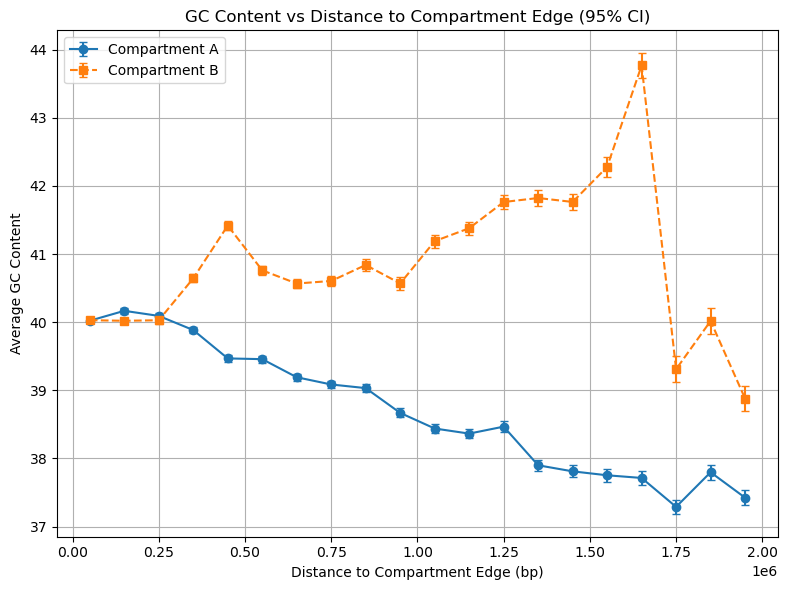

A bin counts: [1616023 1305814 1023420 1010705  865320  793728  743019  663878  627625
  483224  432645  418289  360488  309842  259920  230839  202510  202145
  173044  172958]
B bin counts: [1574095 1078569  774438  585326  476964  462407  424417  375258  323535
  254332  231242  230833  202370  180545  159044  101057   72115   57719
   57896   57751]


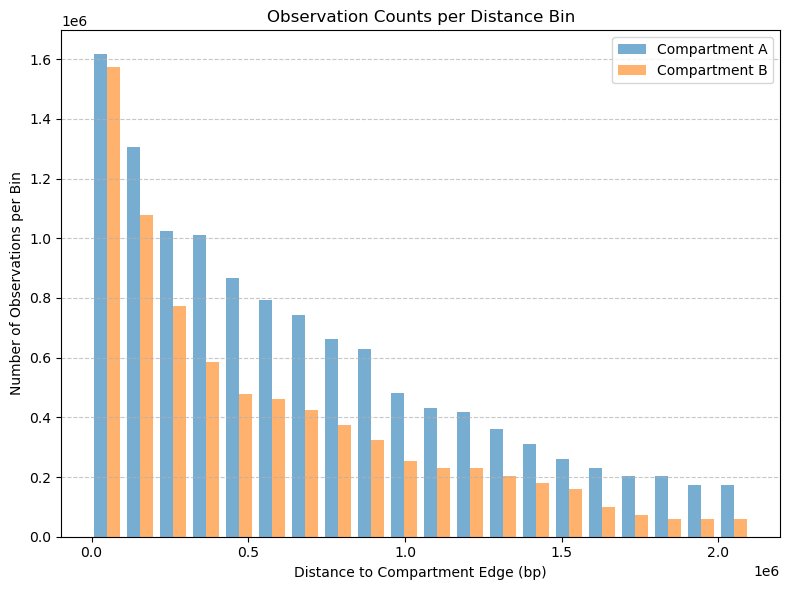

In [12]:
counts = plot_gc_by_compartment_with_error(fibroblast_A, fibroblast_B, return_counts=True)
print("A bin counts:", counts["A_counts"])
print("B bin counts:", counts["B_counts"])

import numpy as np
import matplotlib.pyplot as plt

# Example: from returned dictionary
A_counts = counts["A_counts"]
B_counts = counts["B_counts"]

max_dist = 2_000_000  
num_bins = len(A_counts)

bin_centers = np.linspace(0, max_dist, len(A_counts)) + (max_dist / len(A_counts) / 2)
width = (bin_centers[1] - bin_centers[0]) * 0.4  # width of bars

plt.figure(figsize=(8, 6))
plt.bar(bin_centers - width/2, A_counts, width=width, alpha=0.6, label="Compartment A")
plt.bar(bin_centers + width/2, B_counts, width=width, alpha=0.6, label="Compartment B")

plt.xlabel("Distance to Compartment Edge (bp)")
plt.ylabel("Number of Observations per Bin")
plt.title("Observation Counts per Distance Bin")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

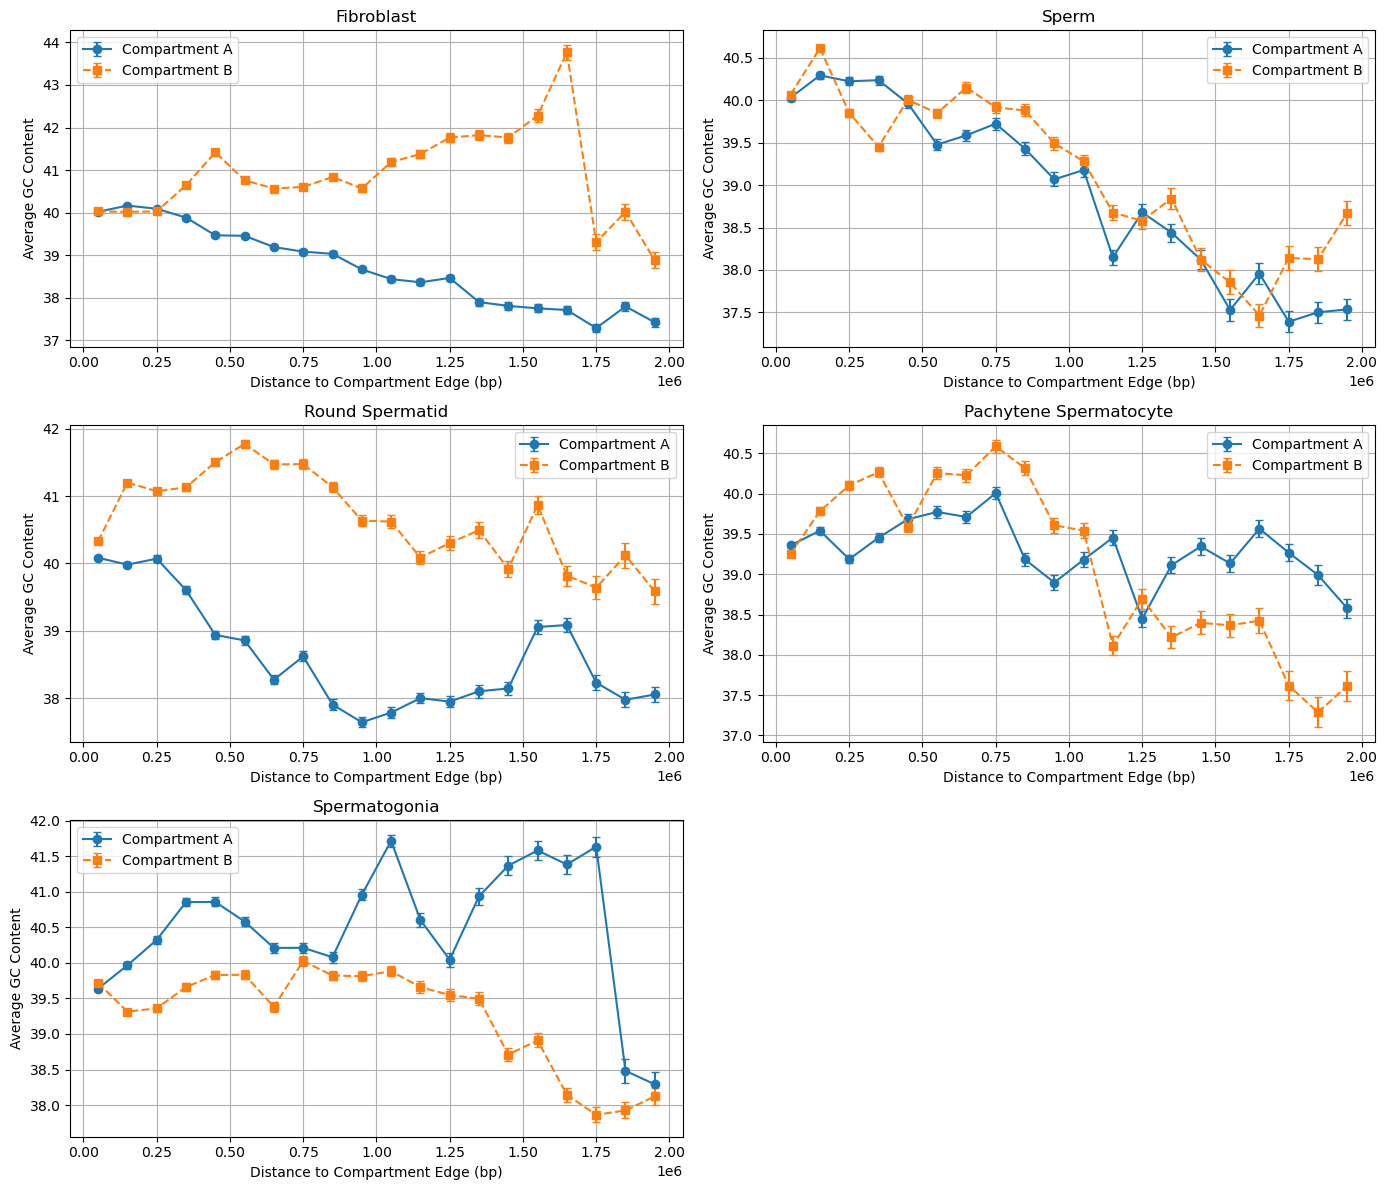

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gc_by_compartment_with_error(ax, A_df, B_df, title, num_bins=20, max_dist=2_000_000):
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    def compute_bin_stats(df):
        means = []
        sems = []
        for i in range(len(bins) - 1):
            bin_data = df[(df['absmid'] >= bins[i]) & (df['absmid'] < bins[i + 1])]
            gc_values = bin_data['value'].dropna()
            if len(gc_values) > 0:
                mean = gc_values.mean()
                sem = gc_values.std(ddof=1) / np.sqrt(len(gc_values)) # standard error of the mean SEM=SAMPLE STANDARD DEVAITION / sqrt(N)
                means.append(mean)
                sems.append(1.96 * sem)  # 95% CI
            else:
                means.append(np.nan)
                sems.append(np.nan)
        return np.array(means), np.array(sems)

    # Split input by compartment
    A_vals = A_df[
        ((A_df['comp'] == 'A') & (A_df['start'] < 0)) |
        ((A_df['comp'] == 'B') & (A_df['start'] > 0))
    ].copy()

    B_vals = B_df[
        ((B_df['comp'] == 'A') & (B_df['start'] > 0)) |
        ((B_df['comp'] == 'B') & (B_df['start'] < 0))
    ].copy()

    A_means, A_errors = compute_bin_stats(A_vals)
    B_means, B_errors = compute_bin_stats(B_vals)

    # Plot
    ax.errorbar(bin_centers, A_means, yerr=A_errors, label="Compartment A",
                marker='o', linestyle='-', capsize=3)
    ax.errorbar(bin_centers, B_means, yerr=B_errors, label="Compartment B",
                marker='s', linestyle='--', capsize=3)

    ax.set_title(title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Average GC Content")
    ax.grid(True)
    ax.legend()


# Prepare plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# List of dataframes and labels
datasets = [
    ("Fibroblast", fibroblast),
    ("Sperm", sperm),
    ("Round Spermatid", round_spermatid),
    ("Pachytene Spermatocyte", pachytene_spermatocyte),
    ("Spermatogonia", spermatogonia),
]

# Loop through and plot
for i, (label, df) in enumerate(datasets):
    plot_gc_by_compartment_with_error(axes[i], df, df, title=label)

# Hide unused subplot if any
for j in range(len(datasets), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



check what A and B means in comp
change error bars so when we redo data into bins we calculate error from that bin???
change color depending on data 


in cpg islands chenk conut of edges (kanter)


recombination or ctcf 